<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

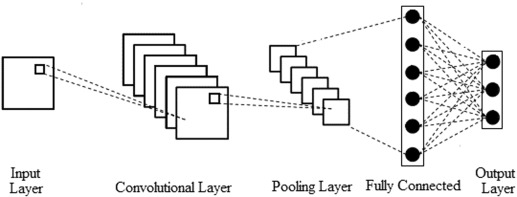

## 1. Load dataset

## 2. Import python libraries and define util functions

In [1]:
''' import '''
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_percentage_error, pearson_corrcoef
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import get_device, get_data_model_path, set_seed, img_read, img_read_plot, plot_loss, plot_rmse, plot_mape

In [2]:
''' set '''
device = get_device()
data_path, model_path = get_data_model_path(os.getcwd())
set_seed(0)

device, data_path, model_path

(device(type='cuda'),
 'd:\\workspace\\study\\DL2\\dataset',
 'd:\\workspace\\study\\DL2\\model')

## 3. Check dataset

## 4. Convert images into trainable data

In [3]:
''' load data '''
src = os.path.join(data_path, 'data_500')
files = os.listdir(src)


X,Y = [],[]

for file in files:
    X.append(img_read(src, file) / 255.0)   # normalize
    Y.append(float(file[:-4]))              # label -> file name

X = np.array(X)
Y = np.array(Y)

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape: (500, 56, 56)
Y.shape: (500,)


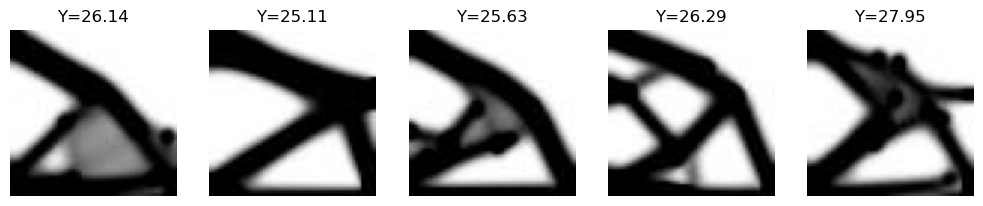

In [4]:
# check images
nplot = 5
idx = np.random.randint(1, 500, nplot)

fig = plt.figure(figsize=(15,5))

for i in range(nplot):
    ax = fig.add_subplot(1, nplot+1, i+1)
    ax.imshow(X[idx[i],:,:], cmap='gray')
    ax.set_title(f"Y={Y[idx[i]]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [10]:
''' train test split '''
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X,Y, test_size=0.2, random_state=1, shuffle=True)

print(X_tr.shape, X_ts.shape, Y_tr.shape,Y_ts.shape)


# normalization (Y: 0~1)
scaler = MinMaxScaler()
Y_tr = scaler.fit_transform(Y_tr.reshape(-1,1)) # (400,) -> (400, 1)
Y_ts = scaler.transform(Y_ts.reshape(-1,1))


# convert to Tensor
X_tr = torch.tensor(X_tr, dtype=torch.float32)
Y_tr = torch.tensor(Y_tr, dtype=torch.float32)
X_ts = torch.tensor(X_ts, dtype=torch.float32)
Y_ts = torch.tensor(Y_ts, dtype=torch.float32)

X_tr = X_tr.unsqueeze(1).to(device) # (400, 56, 56) -> (400, 1, 56, 56) : channel 추가
X_ts = X_ts.unsqueeze(1).to(device)
Y_tr = Y_tr.to(device)              # (400,) -> (400, 1, 1)
Y_ts = Y_ts.to(device)

print(X_tr.size(), X_ts.size())
print(Y_tr.size(), Y_ts.size())

(400, 56, 56) (100, 56, 56) (400,) (100,)
torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


## 6. Set to model architecture

In [ ]:
''' model '''
class CNN(nn.Module):
    def __init__(self, conv_layers_channels=[16, 32, 64], fc_units=[256, 1]):
        super(CNN, self).__init__()

        # automatically determine the number of convolutional layers
        num_conv_layers = len(conv_layers_channels)

        # define the convolutional layers
        self.convs = nn.ModuleList()
        in_channels = 1  # input channels (1 for grayscale images)
        for i in range(num_conv_layers):
            out_channels = conv_layers_channels[i]
            self.convs.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
            in_channels = out_channels  # set the output channels of this layer as input for the next layer

        self.relu = nn.ReLU()  # ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=2)  # Max-pooling with a kernel size of 2

        # calculate the size of the flattened feature map after the convolutional layers
        final_feature_map_size = 56 // (2 ** num_conv_layers)
        conv_output_size = in_channels * final_feature_map_size * final_feature_map_size

        # define the fully connected layers
        self.flatten = nn.Flatten()  # flatten the feature map to prepare for fully connected layers
        self.fcs = nn.ModuleList()
        input_dim = conv_output_size
        for fc_unit in fc_units[:-1]:  # create the hidden fully connected layers
            self.fcs.append(nn.Linear(input_dim, fc_unit))
            input_dim = fc_unit  # update input size for the next fully connected layer

        # define the output layer
        self.fc_out = nn.Linear(input_dim, fc_units[-1])

    def forward(self, x):
        # pass the input through the convolutional layers with ReLU and MaxPooling
        for conv in self.convs:
            x = self.relu(conv(x))
            x = self.maxpool(x)

        # flatten the output from the convolutional layers
        x = self.flatten(x)

        # pass the flattened output through the fully connected layers with ReLU
        for fc in self.fcs:
            x = self.relu(fc(x))

        # pass the output through the final layer
        x = self.fc_out(x)

        return x

In [ ]:
# ''' model '''
# # module
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
#         super(ConvBlock, self).__init__()

#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         return x

# class FcBlock(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(FcBlock, self).__init__()

#         self.fc = nn.Linear(in_features, out_features)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.fc(x)
#         x = self.relu(x)

#         return x


# # model
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()


#         # conv_layers_channels=[64, 128, 256], fc_units=[256, 1]
#         self.flatten = nn.Flatten()

#         self.convs = nn.Sequential(
#             ConvBlock(1, 64, kernel_size=3, padding=1),
#             ConvBlock(64, 128, kernel_size=3, padding=1),
#             ConvBlock(128, 256, kernel_size=3, padding=1),
#         )

#         self.fcs = nn.Sequential(
#             FcBlock(3200, 256),
#             nn.Linear(256, 1)
#         )

#     def forward(self, x):
#         x = self.convs(x)
#         print(x.shape)
#         x = self.flatten(x)
#         print(x.shape)
#         x = self.fcs(x)
#         print(x.shape)

#         return x

## 7. Set model hyperparameters

In [39]:
cnn = CNN().to(device)

summary(cnn, (1, 56, 56))
cnn

torch.Size([2, 256, 5, 5])
torch.Size([2, 6400])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x6400 and 3200x256)

In [9]:
# training parameters

learning_rate = 0.0001  # the rate at which the model learns; smaller values can lead to more precise learning, but too small may slow down training
batch_size = 32  # number of samples processed before updating the model; Increasing batch size can improve training speed, but requires more memory
num_epochs = 100  # number of times the entire training dataset is passed through the model; More epochs allow the model to learn better but may lead to overfitting

## 8. Train model

In [ ]:
# create a DataLoader for the training dataset (includes shuffling)
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# define the loss function (MSE: Mean Squared Error)
criterion = nn.MSELoss()

# set the optimizer (Adam optimizer)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []
rmse_train_history = []
mape_train_history = []

loss_valid_history = []
rmse_valid_history = []
mape_valid_history = []


for epoch in range(num_epochs):

    # training phase
    cnn.train()  # set the model to training mode
    total_loss = 0.0
    rmse_train = 0.0
    mape_train = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # reset the gradients
        outputs = cnn(images).to(device)
        labels = labels.to(device)
        loss = criterion(outputs, labels)  # calculate the loss
        loss.backward()  # backpropagate the loss
        optimizer.step()  # update the model parameters

        # accumulate metrics
        total_loss += loss.item()

        #inverse transformation for calculating metrics
        outputs = outputs.cpu().detach().numpy().reshape(1,-1)
        labels = labels.cpu().detach().numpy().reshape(1,-1)
        outputs = scaler.inverse_transform(outputs)
        labels = scaler.inverse_transform(labels)
        outputs = torch.from_numpy(outputs).clone().detach()#.reshape(1,-1)
        labels  = torch.from_numpy(labels).clone().detach()#.reshape(1,-1)

        rmse_train += mean_squared_error(outputs, labels, squared=False).item() # returns RMSE value if set to False
        mape_train += mean_absolute_percentage_error(outputs, labels).item() * 100

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)
    average_rmse_train = rmse_train / len(train_loader)
    average_mape_train = mape_train / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)
    rmse_train_history.append(average_rmse_train)
    mape_train_history.append(average_mape_train)

    # evaluation phase (disable gradient calculation)
    cnn.eval()
    with torch.no_grad():
        test_outputs = cnn(test_images).to(device)
        loss_val = criterion(test_outputs, test_labels).item()  # calculate the validation loss

        #inverse transformation for calculating metrics
        test_outputs_inv = test_outputs.cpu().detach().numpy().reshape(1,-1)
        test_labels_inv  = test_labels.cpu().detach().numpy().reshape(1,-1)
        test_outputs_inv = scaler.inverse_transform(test_outputs_inv)
        test_labels_inv  = scaler.inverse_transform(test_labels_inv)
        test_outputs_inv = torch.from_numpy(test_outputs_inv).clone().detach().reshape(1,-1)
        test_labels_inv  = torch.from_numpy(test_labels_inv).clone().detach().reshape(1,-1)

        rmse_val = mean_squared_error(test_outputs, test_labels, squared=False).item()  # RMSE for the validation set
        mape_val = mean_absolute_percentage_error(test_outputs, test_labels).item() * 100  # MAPE for the validation set

    # save training metrics
    loss_valid_history.append(loss_val)
    rmse_valid_history.append(rmse_val)
    mape_valid_history.append(mape_val)

    # print training and validation metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], TRAIN_RMSE: {average_rmse_train:.4f}, TRAIN_MAPE: {average_mape_train:.4f}, VAL_RMSE: {rmse_val:.4f}, VAL_MAPE: {mape_val:.4f}")

Epoch [1/100], TRAIN_RMSE: 1.8140, TRAIN_MAPE: 5.6792, VAL_RMSE: 0.2792, VAL_MAPE: 154.2143
Epoch [2/100], TRAIN_RMSE: 1.4769, TRAIN_MAPE: 4.6670, VAL_RMSE: 0.2725, VAL_MAPE: 147.7814
Epoch [3/100], TRAIN_RMSE: 1.4118, TRAIN_MAPE: 4.4640, VAL_RMSE: 0.2619, VAL_MAPE: 136.8499
Epoch [4/100], TRAIN_RMSE: 1.3229, TRAIN_MAPE: 4.1360, VAL_RMSE: 0.2325, VAL_MAPE: 133.8641
Epoch [5/100], TRAIN_RMSE: 1.2187, TRAIN_MAPE: 3.7690, VAL_RMSE: 0.2065, VAL_MAPE: 127.1625
Epoch [6/100], TRAIN_RMSE: 1.1020, TRAIN_MAPE: 3.4560, VAL_RMSE: 0.2174, VAL_MAPE: 89.1539
Epoch [7/100], TRAIN_RMSE: 1.0733, TRAIN_MAPE: 3.3596, VAL_RMSE: 0.1772, VAL_MAPE: 120.3846
Epoch [8/100], TRAIN_RMSE: 0.9137, TRAIN_MAPE: 2.8316, VAL_RMSE: 0.1720, VAL_MAPE: 76.8762
Epoch [9/100], TRAIN_RMSE: 0.8224, TRAIN_MAPE: 2.4905, VAL_RMSE: 0.1456, VAL_MAPE: 69.5997
Epoch [10/100], TRAIN_RMSE: 0.7188, TRAIN_MAPE: 2.1450, VAL_RMSE: 0.1497, VAL_MAPE: 92.6843
Epoch [11/100], TRAIN_RMSE: 0.6988, TRAIN_MAPE: 2.1165, VAL_RMSE: 0.1288, VAL_MAPE:

## 9. Visualize learning history

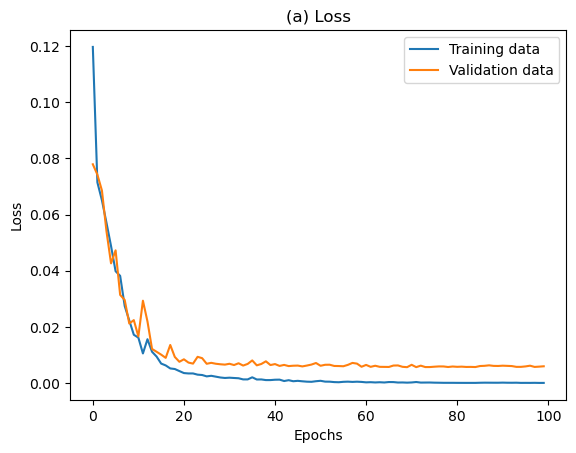

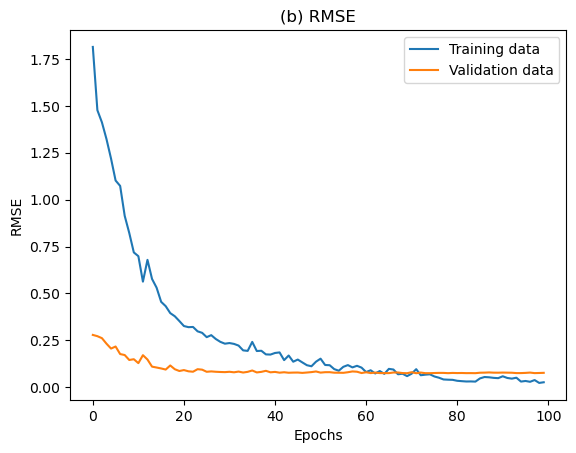

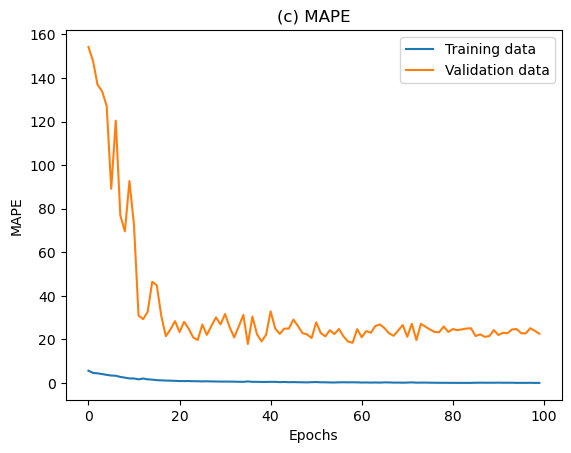

In [11]:
# Graph Visualization
plot_loss(loss_train_history, loss_valid_history, '(a) Loss')  # Loss variation over epochs during training
plt.show()
plot_rmse(rmse_train_history, rmse_valid_history, '(b) RMSE')  # RMSE variation over epochs during training
plt.show()
plot_mape(mape_train_history, mape_valid_history, '(c) MAPE')  # MAPE variation over epochs during training
plt.show()

## 10. Evaluate model performance

 ----- evaluation results ----- 
 
valid RMSE :  0.0771
valid MAPE :  0.1371
valid R2 :  0.9598


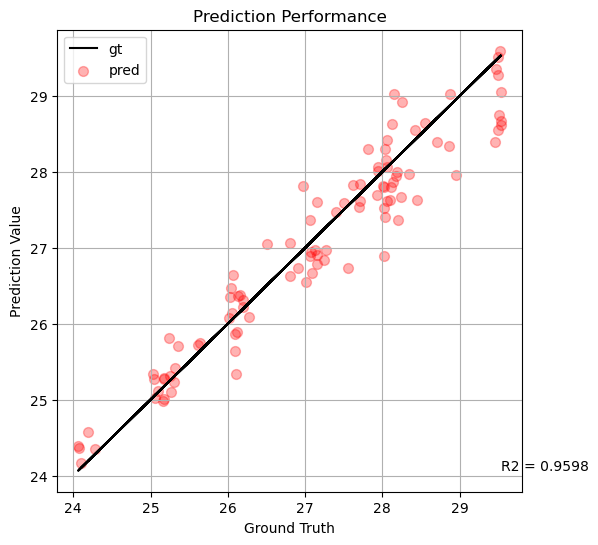

In [ ]:
# load the saved model and set it to evaluation mode
cnn.eval().to(device)

# predict using the model (on the validation dataset)
pred_labels = cnn(test_images)  # returns the predicted values (y_pred)

# evaluate the model performance (RMSE & MAPE)
each_rmse_test = mean_squared_error(pred_labels, test_labels, squared=False).item()
each_mape_test = mean_absolute_percentage_error(test_labels, pred_labels).item()

# calculate and visualize the R2
pred_labels = pred_labels.cpu().detach().numpy()
test_labels = test_labels.cpu().numpy()
pred_labels = scaler.inverse_transform(pred_labels)
test_labels = scaler.inverse_transform(test_labels)


plt.figure(figsize=(6,6))
plt.plot(test_labels, test_labels,'-',color='black')
plt.scatter(test_labels, pred_labels,s=50,alpha=0.3,color='red')
plt.legend(['gt','pred'],loc='upper left')
plt.title('Prediction Performance')
plt.text(test_labels.max(),test_labels.min(),'R2 = {}'.format(round(r_val(test_labels, pred_labels),4)))
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid(True)


# fine-tune your model by minimizing rmse value (validation dataset)
print(" ----- evaluation results ----- ")
print(" ")
print("valid RMSE : " , np.round(each_rmse_test,4))
print("valid MAPE : " , np.round(each_mape_test,4))
print("valid R2 : " , r_val(test_labels, pred_labels))